# 03b - BigQuery ML (BQML) - Boosted Trees For Classification

In this notebook, BigQuery ML (BQML) is used to create a boosted tree model (using XGBoost).

BigQuery has a number of machine learning algorithms callable directly from SQL.  This gives the convenience of using the common language of `SQL` with statments like `CREATE MODEL …`.  The library of available models is constantly growing and covers supervised, unsupervised, and time series methods as well as functions for evaluation - even anomaly detection from results, explainability and hyperparameter tuning.  A great starting point for seeing the scope of available methods is the [user journey for models](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey).

### Prerequisites:
-  01 - BigQuery - Table Data Source

### Resources:
-  [BigQuery ML (BQML) Overview](https://cloud.google.com/bigquery-ml/docs/introduction)
-  [Overview of BQML methods and workflows](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey)

### Conceptual Flow & Workflow
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/03a_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/03a_console.png" width="45%">
</p>

---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [2]:
REGION = 'us-central1'
EXPERIMENT = '03b'
SERIES = '03'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'fraud'
BQ_TABLE = 'fraud_prepped'
BQ_MODEL = f'{EXPERIMENT}_{BQ_DATASET}'

# Resources for serving BigQuery Model Exports
TF_DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest'
XGB_DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.0-82:latest'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [3]:
from google.cloud import bigquery
from google.cloud import aiplatform
from datetime import datetime
import matplotlib.pyplot as plt

clients:

In [4]:
bq = bigquery.Client()
aiplatform.init(project=PROJECT_ID, location=REGION)

parameters:

In [5]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{BQ_DATASET}/models/{SERIES}/{EXPERIMENT}"
RUN_NAME = f'run-{TIMESTAMP}'

---
## Train Model

Use BigQuery ML to train multiclass boosted tree model using XGBoost:
- [Boosted Tree](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-boosted-tree) with BigQuery ML (BQML)
- This uses the `splits` column that notebook `01` created
- `data_split_method = CUSTOM` uses the column in `data_split_col` to assign training data for `FALSE` values and evaluation data for `TRUE` values.
    - in this example the `WHERE splits != 'TEST'` statement filters out the test data and
    - the `CASE` statement maps training data to FALSE and validation data to TRUE

In [6]:
query = f"""
CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
OPTIONS
    (model_type = 'BOOSTED_TREE_CLASSIFIER',
        auto_class_weights = TRUE,
        input_label_cols = ['{VAR_TARGET}'],
        enable_global_explain = TRUE,
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM',
        booster_type = 'GBTREE',
        num_parallel_tree = 1,
        max_iterations = 30,
        early_stop = TRUE,
        min_rel_progress = 0.01,
        tree_method = 'HIST',
        subsample = 0.85
    ) AS
SELECT * EXCEPT({','.join(VAR_OMIT.split())}, splits),
    CASE
        WHEN splits = 'TRAIN' THEN FALSE
        ELSE TRUE
    END AS custom_splits
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
WHERE splits != 'TEST'
"""
job = bq.query(query = query)
job.result()

In [7]:
(job.ended-job.started).total_seconds()

577.355

Add labels to the model in BigQuery:

In [8]:
model = bq.get_model(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
model.labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}
model = bq.update_model(model, ['labels'])

Review the iterations from training with [`ML.TRAINING_INFO`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train):

In [9]:
history = bq.query(
    query = f"""
        SELECT *
        FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        ORDER BY iteration"""
).to_dataframe()
history

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,1,0.460327,0.491448,0.3,101909
1,0,2,0.326295,0.381662,0.3,57
2,0,3,0.240182,0.310906,0.3,70
3,0,4,0.179632,0.271794,0.3,91
4,0,5,0.136129,0.252133,0.3,57
5,0,6,0.104654,0.242260,0.3,57
6,0,7,0.081487,0.227194,0.3,64
7,0,8,0.063889,0.223890,0.3,59
8,0,9,0.050970,0.222946,0.3,60


Plot the loss history:

<AxesSubplot:xlabel='iteration'>

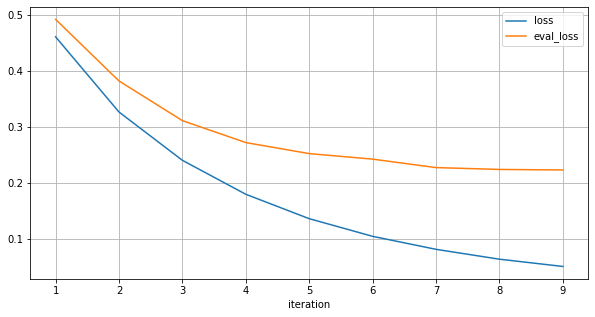

In [10]:
history.plot(x = 'iteration', y = ['loss','eval_loss'], figsize = (10, 5), grid = True)

### Check out this model in BigQuery Console:
- Make sure project selected is the one from this notebook
- Under Explore, expand this project and dataset
- Expand Models and select the model create here

In [11]:
print(f'BigQuery Console for Project:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}')

BigQuery Console for Project:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915


In [12]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{BQ_MODEL}')

Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!5m3!1sstatmike-mlops-349915!2sfraud!3s03b_fraud


---
## Evaluate Model

### Metrics

Review the model evaluation statistics on the splits with [`ML.EVALUATE`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate):

In [13]:
query = f"""
SELECT 'TEST' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='TEST'))
UNION ALL
SELECT 'VALIDATE' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='VALIDATE'))
UNION ALL
SELECT 'TRAIN' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='TRAIN'))
"""
bq.query(query = query).to_dataframe()

,SPLIT,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,TEST,0.396226,0.893617,0.997579,0.549020,0.047299,0.965859
1,TRAIN,0.444569,1.000000,0.997825,0.615504,0.046770,1.000000
2,VALIDATE,0.386792,0.854167,0.997451,0.532468,0.047833,0.984380


### Confusion Matrix

Review the confusion matrix for each split with [`ML.CONFUSION_MATRIX`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-confusion):

In [14]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TRAIN')
  )
"""
bq.query(query = query).to_dataframe()

,expected_label,_0,_1
0,0,227168,496
1,1,0,397


In [15]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'VALIDATE')
  )
"""
bq.query(query = query).to_dataframe()

,expected_label,_0,_1
0,0,28131,65
1,1,7,41


In [16]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
bq.query(query = query).to_dataframe()

,expected_label,_0,_1
0,0,28391,64
1,1,5,42


### ROC Curve

Retrieve the ROC Curve for each split using [`ML.ROC_CURVE`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-roc):

In [17]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TRAIN')
  )
"""
train_roc = bq.query(query = query).to_dataframe()
train_roc.head()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,0.969820,0.002519,0.000000,1,0,227664,396
1,0.271185,1.000000,0.008297,397,1889,225775,0
2,0.169970,1.000000,0.018396,397,4188,223476,0
3,0.129616,1.000000,0.028467,397,6481,221183,0
4,0.107776,1.000000,0.038280,397,8715,218949,0


In [18]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'VALIDATE')
  )
"""
val_roc = bq.query(query = query).to_dataframe()
val_roc.head()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,0.969680,0.687500,0.000177,33,5,28191,15
1,0.269013,0.854167,0.008512,41,240,27956,7
2,0.171308,0.895833,0.018336,43,517,27679,5
3,0.131791,0.895833,0.028515,43,804,27392,5
4,0.107183,0.916667,0.038516,44,1086,27110,4


In [19]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
test_roc = bq.query(query = query).to_dataframe()
test_roc.head()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,0.969680,0.702128,0.000141,33,4,28451,14
1,0.271861,0.893617,0.008575,42,244,28211,5
2,0.169974,0.914894,0.018450,43,525,27930,4
3,0.127266,0.914894,0.028712,43,817,27638,4
4,0.106907,0.914894,0.038728,43,1102,27353,4


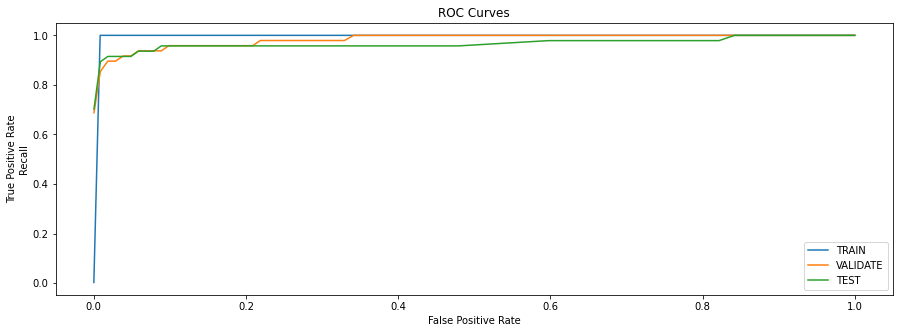

In [20]:
plt.figure(figsize=(15,5))
plt.plot(train_roc['false_positive_rate'], train_roc['recall'], label='TRAIN')
plt.plot(val_roc['false_positive_rate'], val_roc['recall'], label='VALIDATE')
plt.plot(test_roc['false_positive_rate'], test_roc['recall'], label='TEST')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate\nRecall')
plt.title('ROC Curves')
plt.legend()
plt.show()

---
## Predictions

Create a pandas dataframe with predictions for the test data in the table:

In [21]:
query = f"""
SELECT *
FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
pred = bq.query(query = query).to_dataframe()

Review columns from the predictions - note that the query added columns with prefix `predicted_`

In [22]:
pred.columns

Index(['predicted_Class', 'predicted_Class_probs', 'Time', 'V1', 'V2', 'V3',
       'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14',
       'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24',
       'V25', 'V26', 'V27', 'V28', 'Amount', 'Class', 'transaction_id',
       'splits'],
      dtype='object')

Print the first few rows for the columns related to the actual and predicted values:

In [23]:
pred[[VAR_TARGET, f'predicted_{VAR_TARGET}', f'predicted_{VAR_TARGET}_probs', 'splits']].head()

,Class,predicted_Class,predicted_Class_probs,splits
0,0,0,"[{'label': 1, 'prob': 0.04026387631893158}, {'...",TEST
1,0,0,"[{'label': 1, 'prob': 0.030016925185918808}, {...",TEST
2,0,0,"[{'label': 1, 'prob': 0.058800168335437775}, {...",TEST
3,0,0,"[{'label': 1, 'prob': 0.02959824912250042}, {'...",TEST
4,0,0,"[{'label': 1, 'prob': 0.03861048072576523}, {'...",TEST


Notice the nested dictionary for predicted probabilities.  In BigQuery this is a Record type structure with nested fields for `label` and `prop`.  This is returned to the pandas dataframe as a nested dictionary.

The following code sorts the dictionary for the first record by `prob`:

In [24]:
exec('temp = pred.predicted_'+VAR_TARGET+'_probs[0]')
[sorted(x, key = lambda x: x['label']) for x in [temp]]

[[{'label': 0, 'prob': 0.9597361087799072},
  {'label': 1, 'prob': 0.04026387631893158}]]

---
## Explanations
[Built-in](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-xai-overview) capabilities to understand how features contributed to predictions both individually (local) and overall (global).

### Local Explainability
Retrieve feature attribution values to interpret each features contribution to a prediction relative to the baseline prediction using [`ML.EXPLAIN_PREDICT`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict).

In [25]:
query = f"""
SELECT *
FROM ML.EXPLAIN_PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST'), STRUCT(10 as top_k_features)
  )
"""
explain = bq.query(query = query).to_dataframe()

In [26]:
explain.head()

,predicted_Class,probability,top_feature_attributions,baseline_prediction_value,prediction_value,approximation_error,Time,V1,V2,V3,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,0,0.959736,"[{'feature': 'V14', 'attribution': 0.646070361...",0.441709,2.375732,0.0,35337,1.092844,-0.013230,1.359829,...,-0.167647,0.027557,0.592115,0.219695,0.036970,0.010984,0.0,0,a1b10547-d270-48c0-b902-7a0f735dadc7,TEST
1,0,0.969983,"[{'feature': 'V14', 'attribution': 0.783642709...",0.441709,2.242386,0.0,60481,1.238973,0.035226,0.063003,...,-0.057718,0.104983,0.537987,0.589563,-0.046207,-0.006212,0.0,0,814c62c8-ade4-47d5-bf83-313b0aafdee5,TEST
2,0,0.941200,"[{'feature': 'V4', 'attribution': -0.599249482...",0.441709,2.015665,0.0,139587,1.870539,0.211079,0.224457,...,0.180776,-0.060226,-0.228979,0.080827,0.009868,-0.036997,0.0,0,d08a1bfa-85c5-4f1b-9537-1c5a93e6afd0,TEST
3,0,0.970402,"[{'feature': 'V14', 'attribution': 0.446003019...",0.441709,2.255982,0.0,162908,-3.368339,-1.980442,0.153645,...,-1.171627,0.214333,-0.159652,-0.060883,1.294977,0.120503,0.0,0,802f3307-8e5a-4475-b795-5d5d8d7d0120,TEST
4,0,0.961390,"[{'feature': 'V14', 'attribution': 0.532211601...",0.441709,1.981724,0.0,165236,2.180149,0.218732,-2.637726,...,-0.176957,0.563779,0.730183,0.707494,-0.131066,-0.090428,0.0,0,c8a5b93a-1598-4689-80be-4f9f5df0b8ce,TEST


Create a plot of feature attributions for a single prediction:

In [27]:
explanation = explain.iloc[0]['top_feature_attributions']

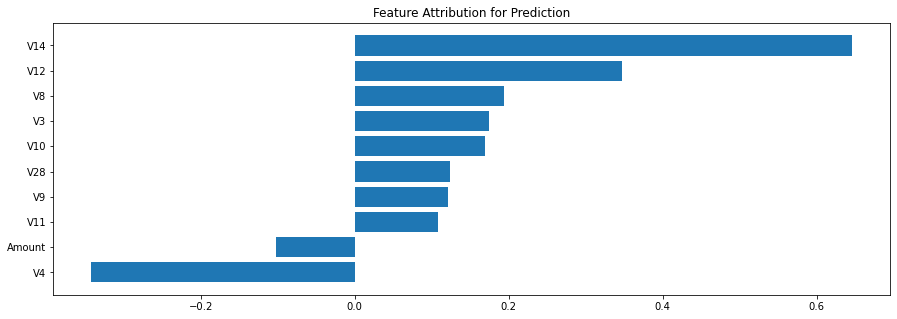

In [28]:
features = []
scores = []
for k in explanation:
    features.append(k['feature'])
    scores.append(k['attribution'])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)

plt.figure(figsize=(15,5))
plt.barh(features, scores)
plt.title('Feature Attribution for Prediction')
plt.show()

### Global Explainability
Retrieve the influence of each feature on the model with [`ML.GLOBAL_EXPLAIN`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-global-explain).  

In [29]:
query = f"""
SELECT *
FROM ML.GLOBAL_EXPLAIN (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
"""
gexplain = bq.query(query = query).to_dataframe()

In [30]:
gexplain.head()

,feature,attribution
0,V14,0.605392
1,V4,0.310194
2,V12,0.244157
3,V11,0.196896
4,V3,0.130351


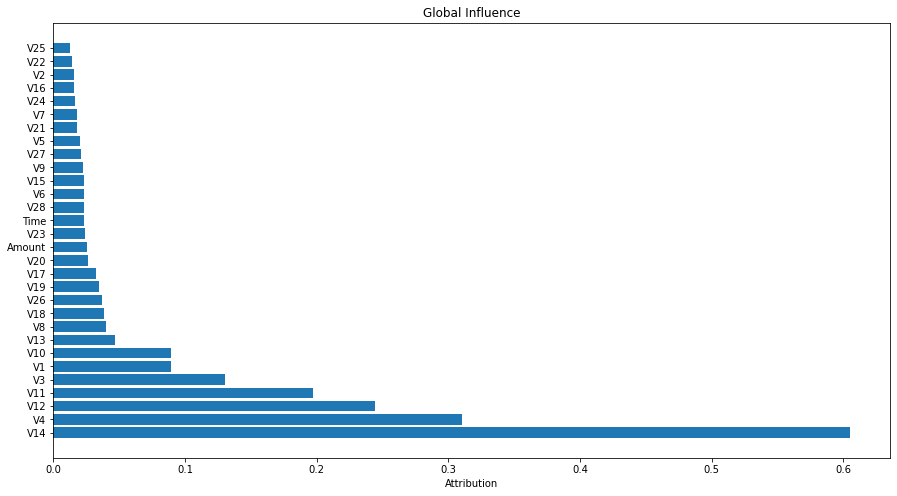

In [31]:
plt.figure(figsize=(15,8))
plt.barh(gexplain['feature'], gexplain['attribution'])
plt.title('Global Influence')
plt.xlabel('Attribution')
#plt.ylabel('Feature')
plt.show()

### Feature Importance

Retrieve the [XGBoost feature importances](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor.feature_importances_) for the model using [`ML.FEATURE_IMPORTANCE`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-importance).
- importance_weight: the number of splits the feature was used in across all trees
- importance_gain: the improvement in accuracy due to splits using the feature
- importance_cover: the number of rows of data covered by splits using the feature

In [32]:
query = f"""
SELECT *
FROM ML.FEATURE_IMPORTANCE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
"""
feature_importance = bq.query(query = query).to_dataframe()

In [38]:
feature_importance

,feature,importance_weight,importance_gain,importance_cover
0,Time,14,103.052365,1350.752577
1,V1,34,86.742955,7904.416930
2,V2,11,160.416991,1031.262319
3,V3,31,96.531963,7889.327844
4,V4,65,563.525315,13917.183521
5,V5,8,85.179212,1038.507303
6,V6,5,163.482529,2790.038624
7,V7,19,152.399725,11330.909768
8,V8,20,321.844586,3186.393879
9,V9,19,163.751114,1989.344756


---
## Serving With Vertex AI

This demonstration shows the process of exporting and registering a BQML model with Vertex AI Model Registry.  To directly integrate BQML with Vertex AI Model Registry it is now (April 1, 2022) possible at model creation time with options `vertex_ai_model_id` and `vertex_ai_model_version_alises`. See the documentation for this direct integration [here](https://cloud.google.com/bigquery-ml/docs/managing-models-vertex).

### Export the BigQuery Model

Reference: [Export the BigQuery Model](https://cloud.google.com/bigquery-ml/docs/exporting-models)

In [39]:
query = f"""
EXPORT MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
    OPTIONS (URI = '{URI}/{TIMESTAMP}/model')
"""
export = bq.query(query = query)
export.result()

In [40]:
(export.ended - export.started).total_seconds()

2.642

In [41]:
listing = !gsutil ls {URI}/{TIMESTAMP}/model
listing

['gs://statmike-mlops-349915/fraud/models/03/03b/20220908173743/model/main.py',
 'gs://statmike-mlops-349915/fraud/models/03/03b/20220908173743/model/model.bst',
 'gs://statmike-mlops-349915/fraud/models/03/03b/20220908173743/model/xgboost_predictor-0.1.tar.gz',
 'gs://statmike-mlops-349915/fraud/models/03/03b/20220908173743/model/assets/']

In [42]:
print(f"View the export in the console:\nhttps://console.cloud.google.com/storage/browser/{URI.split('//')[-1]}/{TIMESTAMP}/model?project={PROJECT_ID}")

View the export in the console:
https://console.cloud.google.com/storage/browser/statmike-mlops-349915/fraud/models/03/03b/20220908173743/model?project=statmike-mlops-349915


### Detect The Model Types Framework

In [43]:
filetype = {'pb': 'TensorFlow', 'bst': 'XGBoost'}

filetypes = [filetype[f.split('.')[-1]] for f in listing if f.split('.')[-1] in ['pb','bst']]
if len(filetypes) == 1:
    framework = filetypes[0]
    print(f'framework = {framework}')
else:
    raise TypeError(f"Model Type Undeteremined!! Review the contents of of 'listing = {listing}'.")

framework = XGBoost


Set the `DEPLOY_IMAGE` based on the framework:

In [44]:
if framework == 'TensorFlow':
    DEPLOY_IMAGE = TF_DEPLOY_IMAGE
elif framework == 'XGBoost':
    DEPLOY_IMAGE = XGB_DEPLOY_IMAGE
    
DEPLOY_IMAGE

'us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.0-82:latest'

### Upload The Model To Vertex AI Model Registry
References:
- Python SDK for [`aiplatform.Model`](https://googleapis.dev/python/aiplatform/latest/aiplatform/services.html#google.cloud.aiplatform.Model)
- Python Client for [`aiplatform.Model`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model)

In [45]:
modelmatch = aiplatform.Model.list(filter = f'labels.series={SERIES} AND labels.experiment={EXPERIMENT}')

upload_model = True
if modelmatch:
    print("Model Already in Registry:")
    if RUN_NAME in modelmatch[0].version_aliases:
        print("This version already loaded, no action taken.")
        upload_model = False
        model = aiplatform.Model(model_name = modelmatch[0].resource_name)
    else:
        print('Loading model as new default version.')
        parent_model =  modelmatch[0].resource_name
else:
    print('This is a new model, creating in model registry')
    parent_model = ''

if upload_model:
    model = aiplatform.Model.upload(
        display_name = f'{EXPERIMENT}_{BQ_DATASET}',
        model_id = f'model_{EXPERIMENT}_{BQ_DATASET}',
        parent_model = parent_model,
        serving_container_image_uri = DEPLOY_IMAGE,
        artifact_uri = f"{URI}/{TIMESTAMP}/model",
        is_default_version = True,
        version_aliases = [RUN_NAME],
        version_description = RUN_NAME,
        labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}', 'run_name' : f'{RUN_NAME}', 'framework' : f'{framework.lower()}'}
    )  

This is a new model, creating in model registry
Creating Model
Create Model backing LRO: projects/1026793852137/locations/us-central1/models/model_03b_fraud/operations/6603099832020107264
Model created. Resource name: projects/1026793852137/locations/us-central1/models/556172563747700736@1
To use this Model in another session:
model = aiplatform.Model('projects/1026793852137/locations/us-central1/models/556172563747700736@1')


In [46]:
model.display_name

'03b_fraud'

In [47]:
model.resource_name

'projects/1026793852137/locations/us-central1/models/556172563747700736'

In [48]:
print(f"View the model in the Vertex AI Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/model_{EXPERIMENT}_{BQ_DATASET}?project={PROJECT_ID}")

View the model in the Vertex AI Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/model_03b_fraud?project=statmike-mlops-349915


---
## Online Predictions with Vertex AI Endpoints
Check out the notebook `03Tools - Predictions` to see how to use this model with [online predictions in Vertex AI](https://cloud.google.com/vertex-ai/docs/predictions/online-predictions-custom-models).

---
## Remove Resources
see notebook "99 - Cleanup"